# Classifying text with BERT


## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [1]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=fcbe3f000e65ace13dfbb68cb0737b19cee19793a443a22f522c44fb6431d407
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import os
import shutil
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [3]:
dataset = pd.read_csv('/kaggle/input/hate-speech/Hate speech excel file (1).csv', encoding='latin-1')

In [4]:
dataset.head()

,Unnamed: 0,id,segment_id,title,caption_segment,sentiment
0,0,#NAME?,#NAME?,LIVE l PM Stresses On Zero Tolerance To Terror...,freedom and civilization it knows no boundarie...,1.0
1,1,lpYVmd8a1rY,lpYVmd8a1rY_1,Reading park stabbings: UK Labour leader react...,well this was just a horrific incident and our...,1.0
2,2,lpYVmd8a1rY,lpYVmd8a1rY_2,Reading park stabbings: UK Labour leader react...,runs its course but I will want to work with t...,-1.0
3,3,lpYVmd8a1rY,lpYVmd8a1rY_3,Reading park stabbings: UK Labour leader react...,moment investigation has to take its course bu...,1.0
4,4,lpYVmd8a1rY,lpYVmd8a1rY_4,Reading park stabbings: UK Labour leader react...,our responders the NHS and the police yet agai...,-1.0


In [5]:
dataset['sentiment'].isnull().sum()

50

In [6]:
dataset.dropna(subset=['sentiment'], inplace=True)

In [7]:
dataset['sentiment']=dataset['sentiment'].apply(lambda x : 1 if x==1.0 else 0)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=seed)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=seed)

train_ds = tf.data.Dataset.from_tensor_slices((train_data['caption_segment'].values, train_data['sentiment'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_data['caption_segment'].values, val_data['sentiment'].values))  # Make sure to use the correct column names
test_ds = tf.data.Dataset.from_tensor_slices((test_data['caption_segment'].values, test_data['sentiment'].values))  # Ensure test_data is defined

train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

Let's take a look at a few reviews.

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [10]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [11]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [12]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [16]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.86307955]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

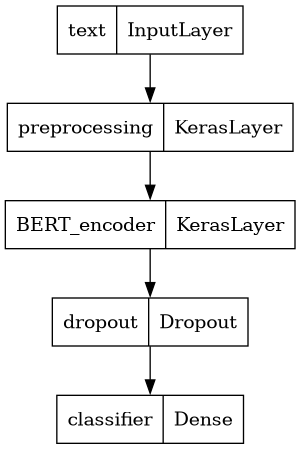

In [17]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(curve="ROC", summation_method="interpolation", name='auc')
]

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [19]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [20]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=METRICS)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [22]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
30/30 [==============================] - 157s 5s/step - loss: 0.5276 - accuracy: 0.7400 - precision: 0.7895 - recall: 0.5237 - auc: 0.7501 - val_loss: 0.5130 - val_accuracy: 0.7353 - val_precision: 0.7969 - val_recall: 0.5050 - val_auc: 0.7617
Epoch 2/5
30/30 [==============================] - 139s 5s/step - loss: 0.4260 - accuracy: 0.7884 - precision: 0.8571 - recall: 0.5985 - auc: 0.8149 - val_loss: 0.5045 - val_accuracy: 0.7647 - val_precision: 0.7528 - val_recall: 0.6634 - val_auc: 0.7777
Epoch 3/5
30/30 [==============================] - 138s 5s/step - loss: 0.3693 - accuracy: 0.8337 - precision: 0.9064 - recall: 0.6758 - auc: 0.8438 - val_loss: 0.5186 - val_accuracy: 0.7479 - val_precision: 0.7071 - val_recall: 0.6931 - val_auc: 0.7904
Epoch 4/5
30/30 [==============================] - 138s 5s/step - loss: 0.3434 - accuracy: 0.8358 - precision: 0.9070 - recall: 0.6808 - auc: 0.84

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [23]:
results = classifier_model.evaluate(test_ds)

print(f'Loss: {results[0]}')
print(f'Accuracy: {results[1]}')
print(f'Precision: {results[2]}')
print(f'Recall: {results[3]}')
print(f'AUC: {results[4]}')

10/10 [==============================] - 12s 1s/step - loss: 0.4077 - accuracy: 0.8182 - precision: 0.7757 - recall: 0.7345 - auc: 0.8325
Loss: 0.40772300958633423
Accuracy: 0.8181818127632141
Precision: 0.7757009267807007
Recall: 0.7345132827758789
AUC: 0.8324835896492004


### Plotting the ROC

1/1 [==============================] - 1s 842ms/step


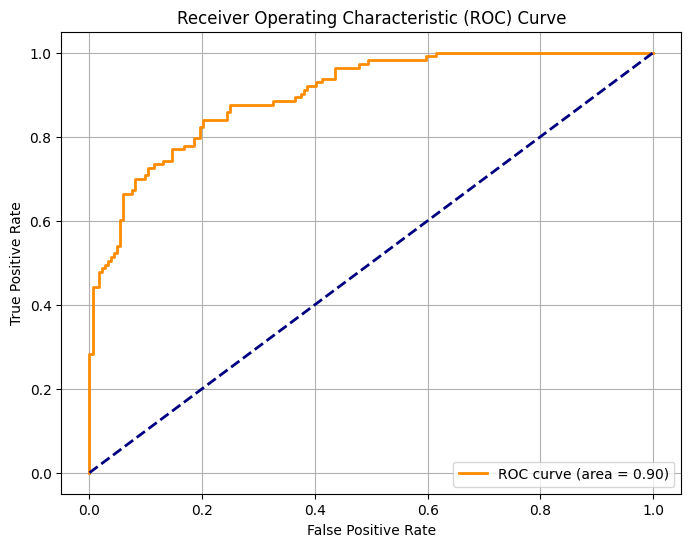

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities
y_true = []
y_pred_prob = []

for texts, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_prob.extend(classifier_model.predict(texts).ravel())

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()